Train Epoch: 0 [0/90 (0%)]	 Average loss: 0.102396
Train Epoch: 0 [40/90 (43%)]	 Average loss: 0.046716
Train Epoch: 0 [80/90 (87%)]	 Average loss: 0.029809
Test set: Average loss: 0.024681
Train Epoch: 1 [0/90 (0%)]	 Average loss: 0.025662
Train Epoch: 1 [40/90 (43%)]	 Average loss: 0.017183
Train Epoch: 1 [80/90 (87%)]	 Average loss: 0.010877
Test set: Average loss: 0.011924
Train Epoch: 2 [0/90 (0%)]	 Average loss: 0.009994
Train Epoch: 2 [40/90 (43%)]	 Average loss: 0.008232
Train Epoch: 2 [80/90 (87%)]	 Average loss: 0.007704
Test set: Average loss: 0.009257
Train Epoch: 3 [0/90 (0%)]	 Average loss: 0.006366
Train Epoch: 3 [40/90 (43%)]	 Average loss: 0.005599
Train Epoch: 3 [80/90 (87%)]	 Average loss: 0.007957
Test set: Average loss: 0.007637
Train Epoch: 4 [0/90 (0%)]	 Average loss: 0.005199
Train Epoch: 4 [40/90 (43%)]	 Average loss: 0.005951
Train Epoch: 4 [80/90 (87%)]	 Average loss: 0.004459
Test set: Average loss: 0.006871
Train Epoch: 5 [0/90 (0%)]	 Average loss: 0.003741

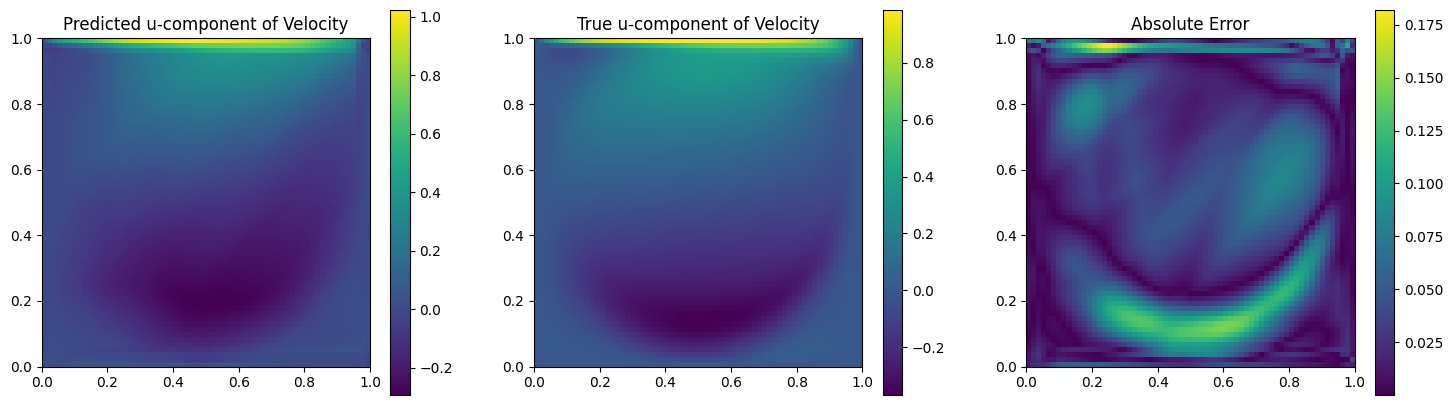

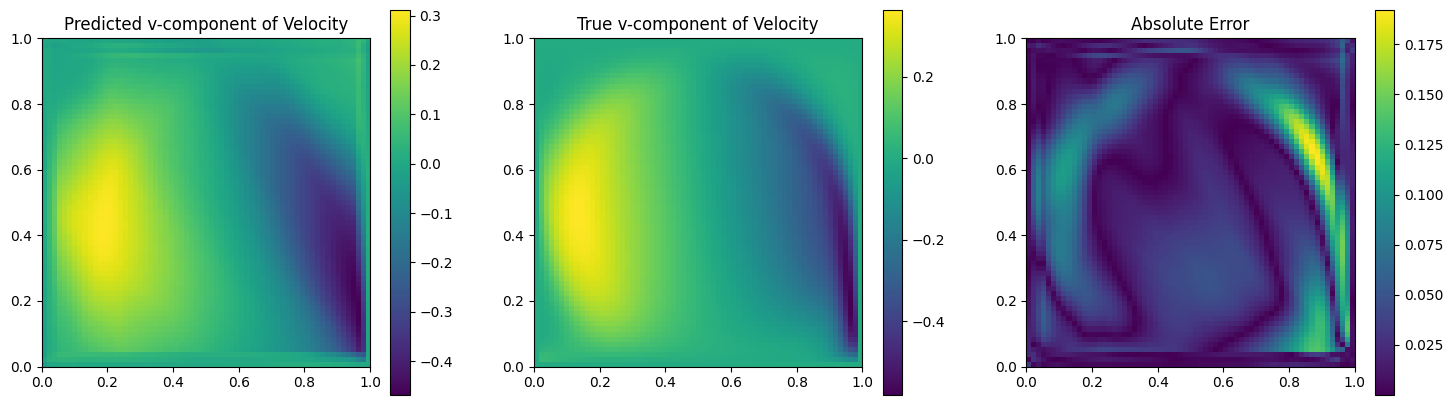

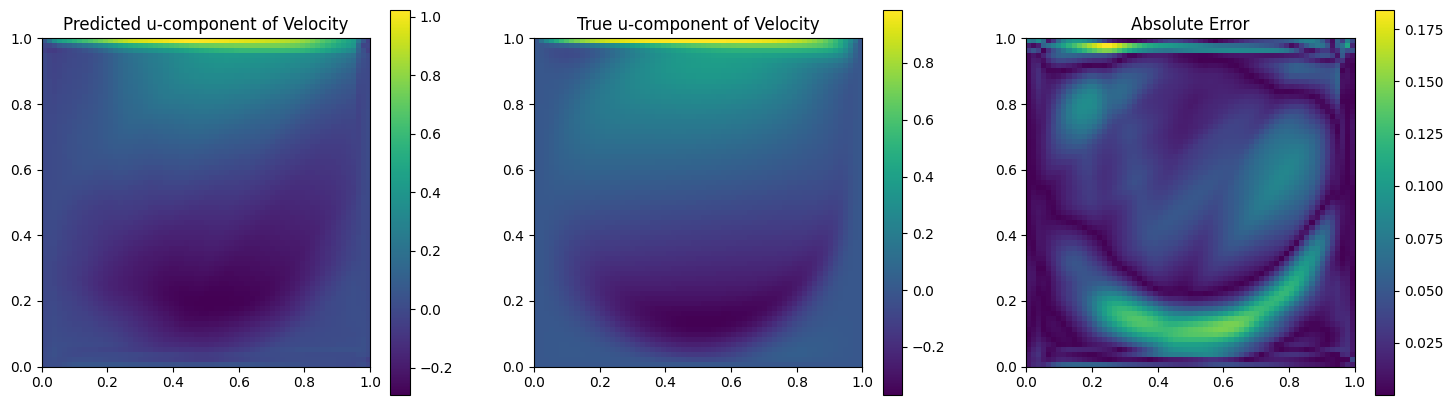

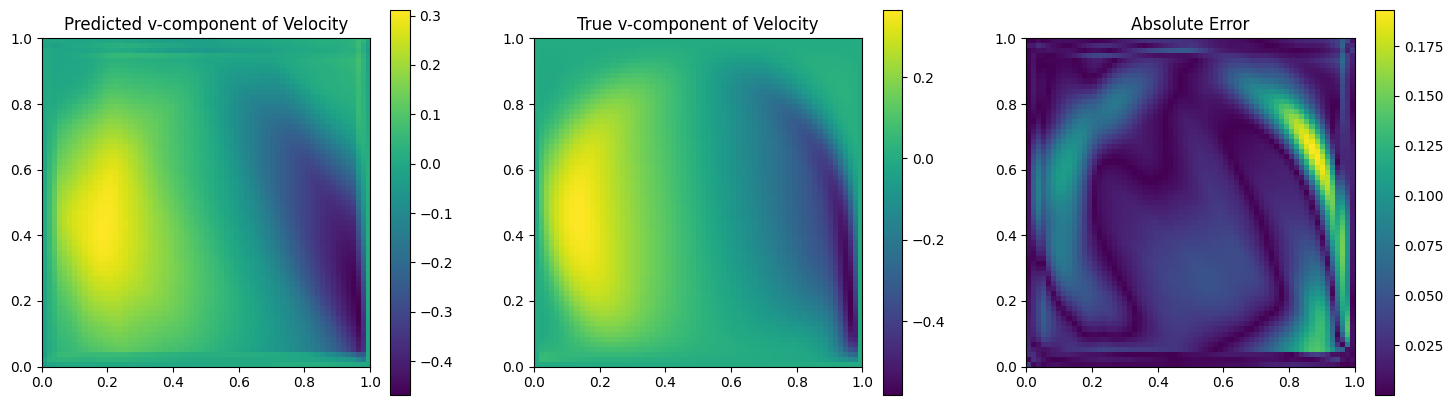

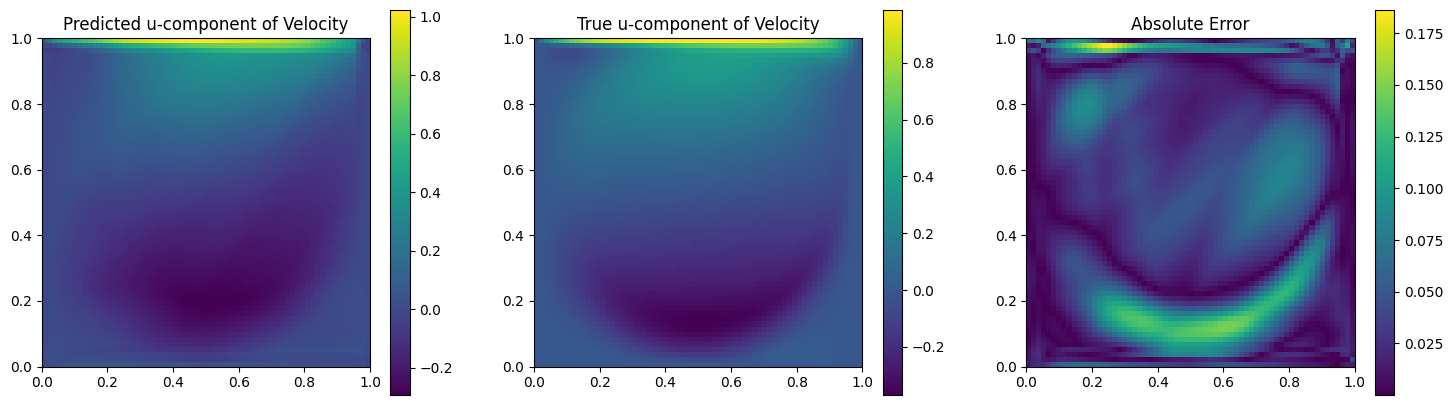

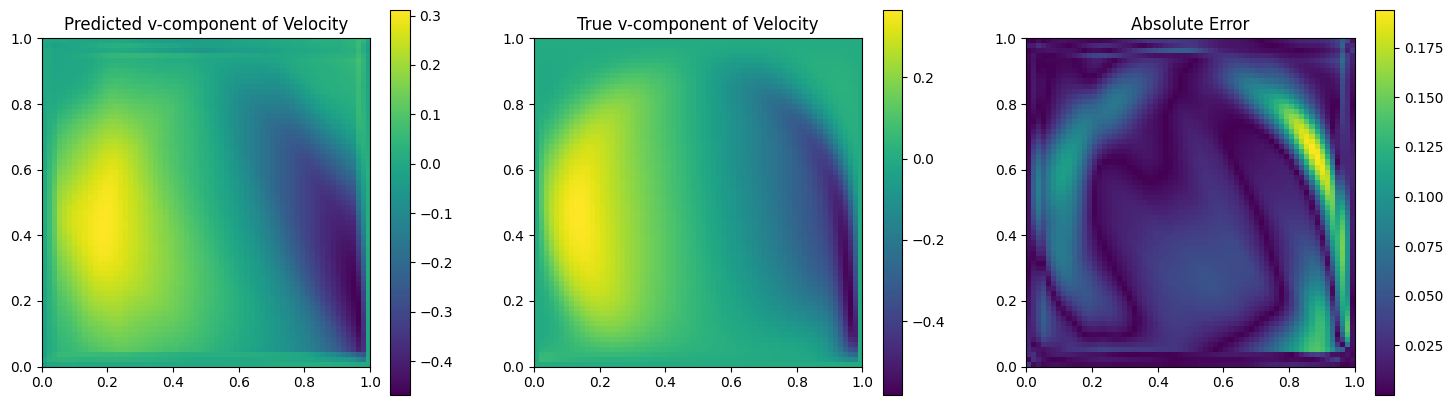

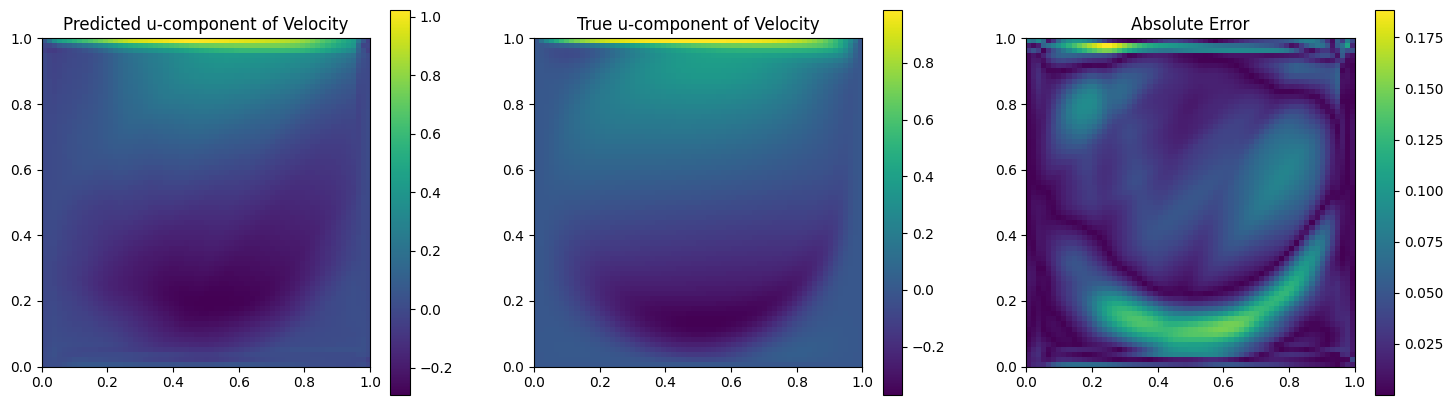

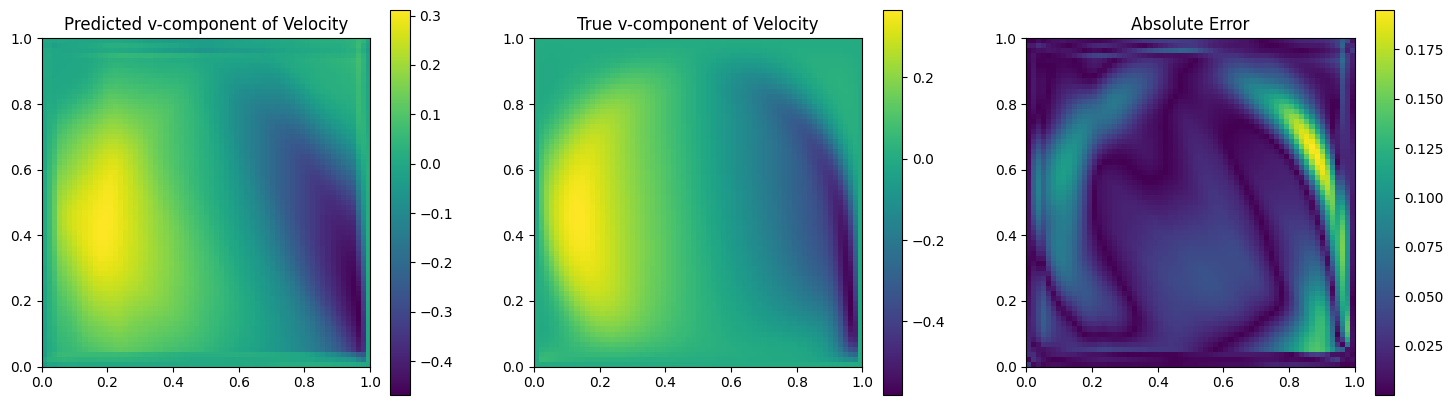

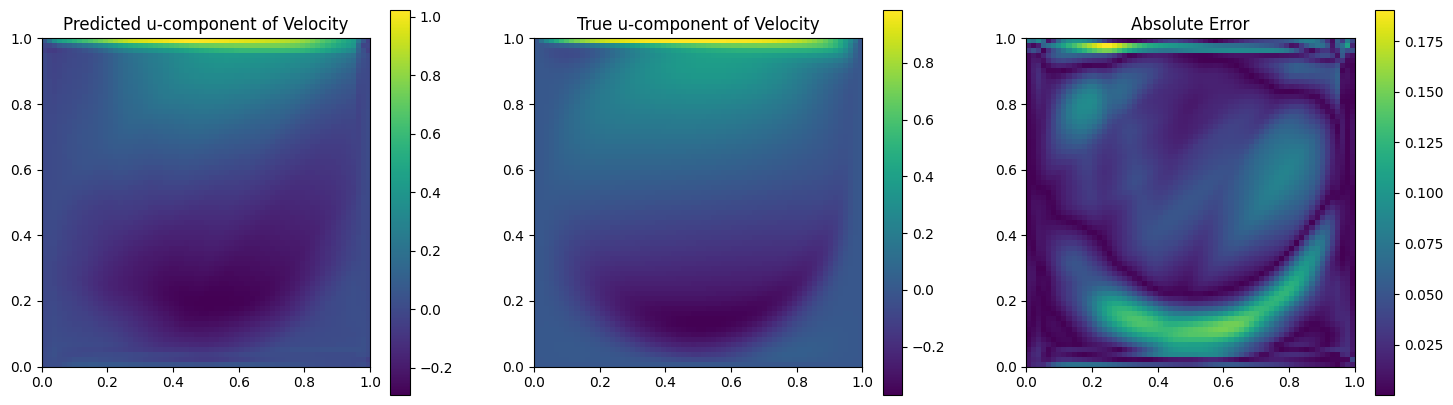

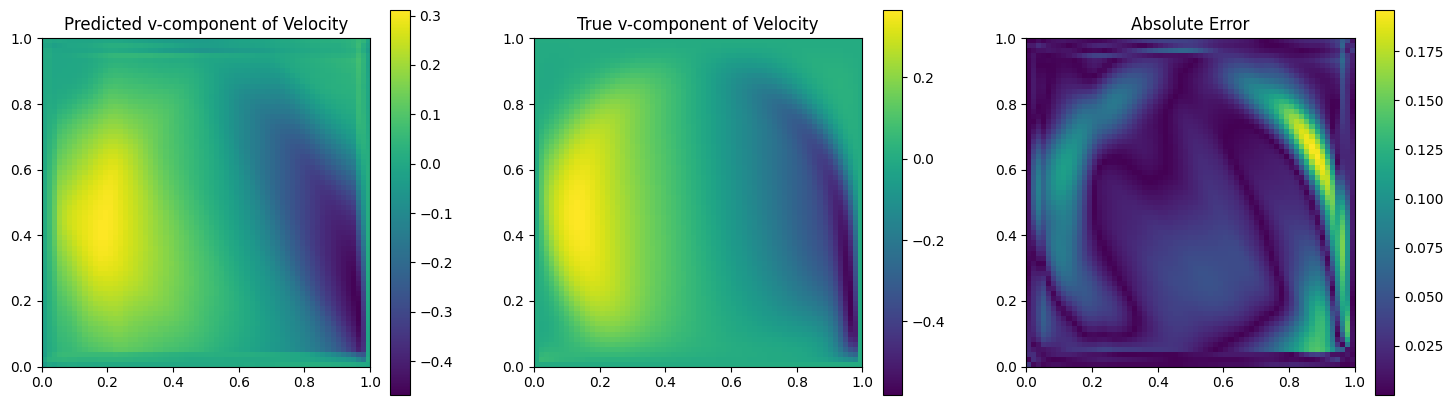

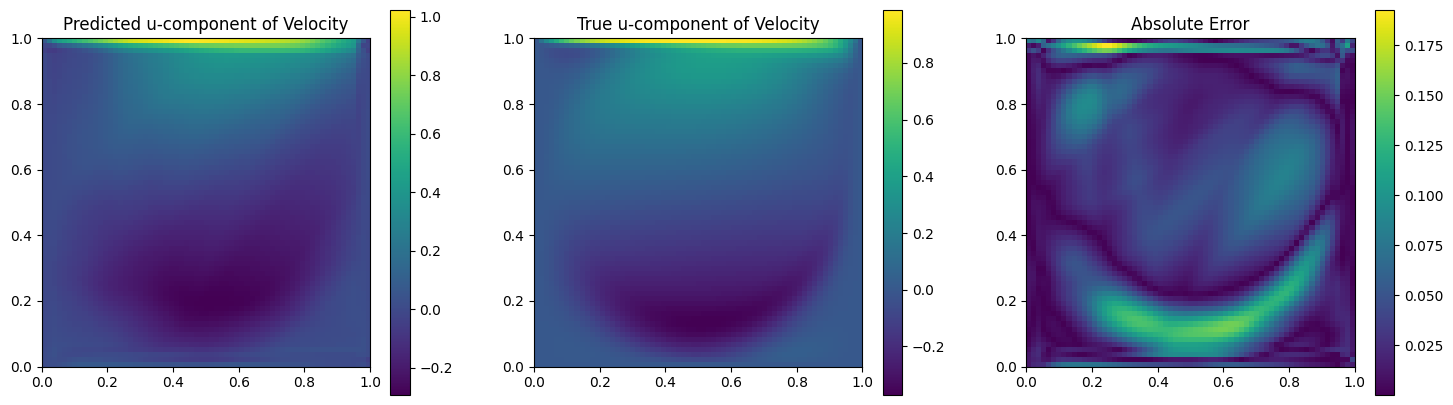

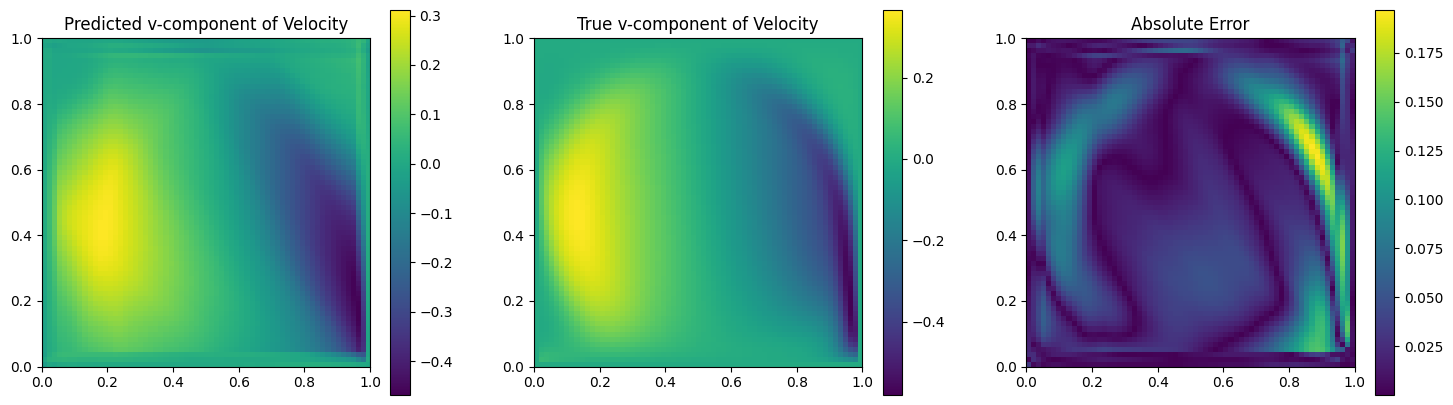

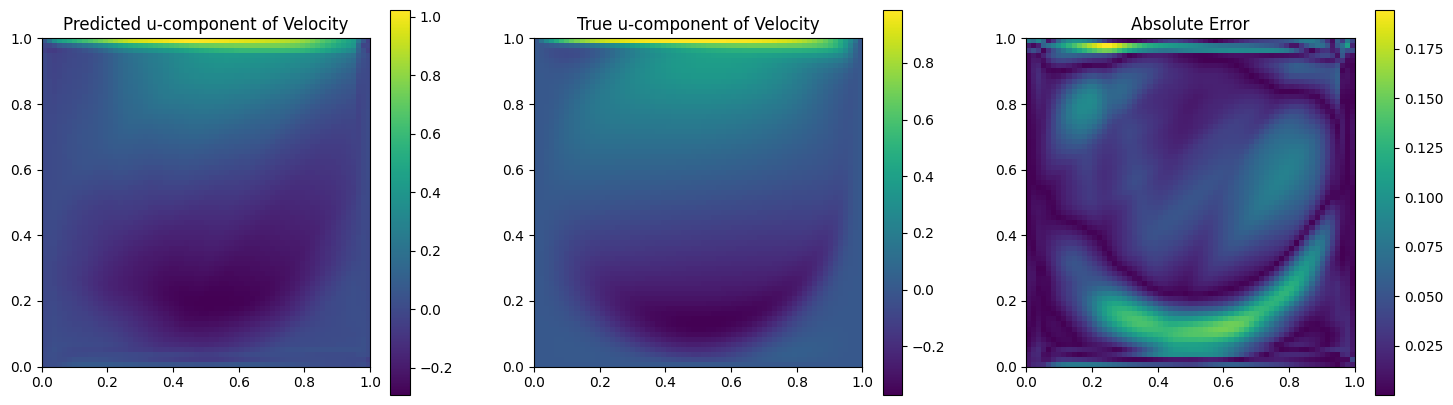

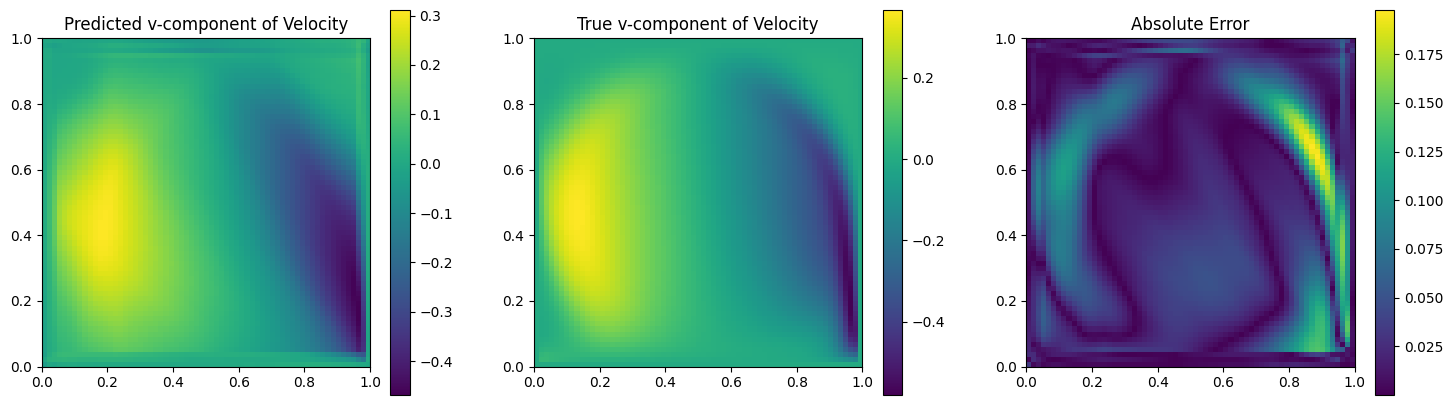

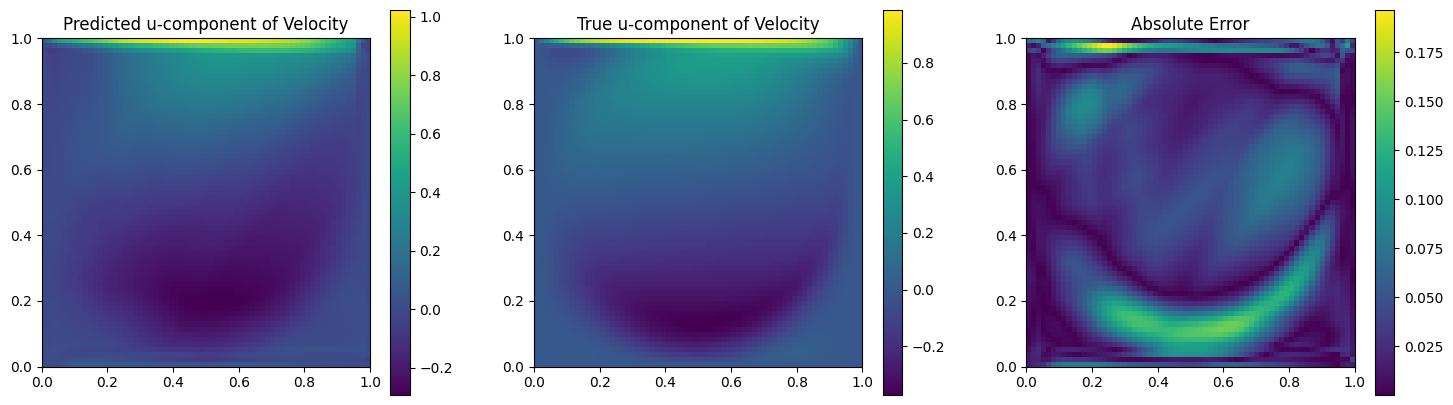

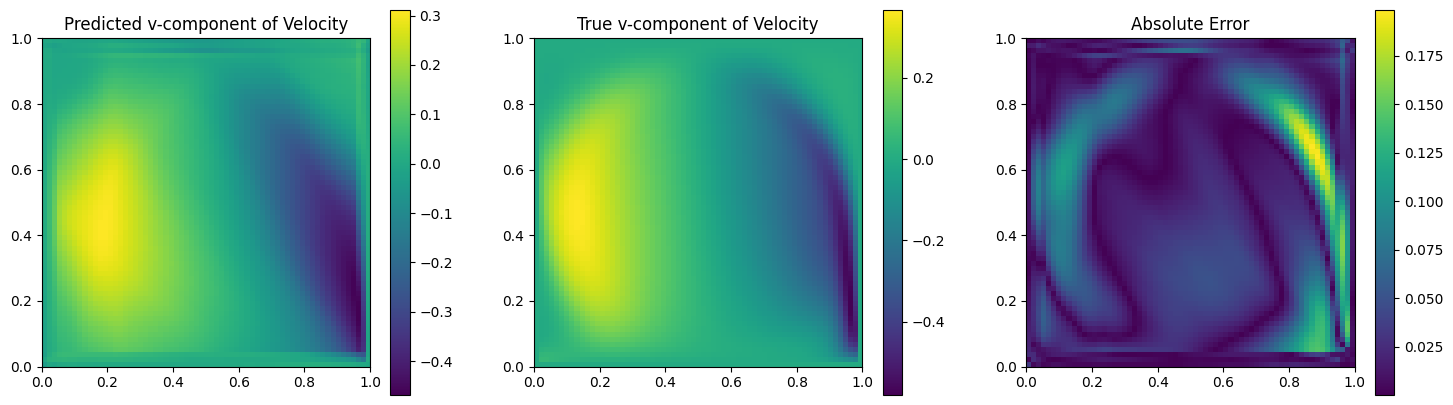

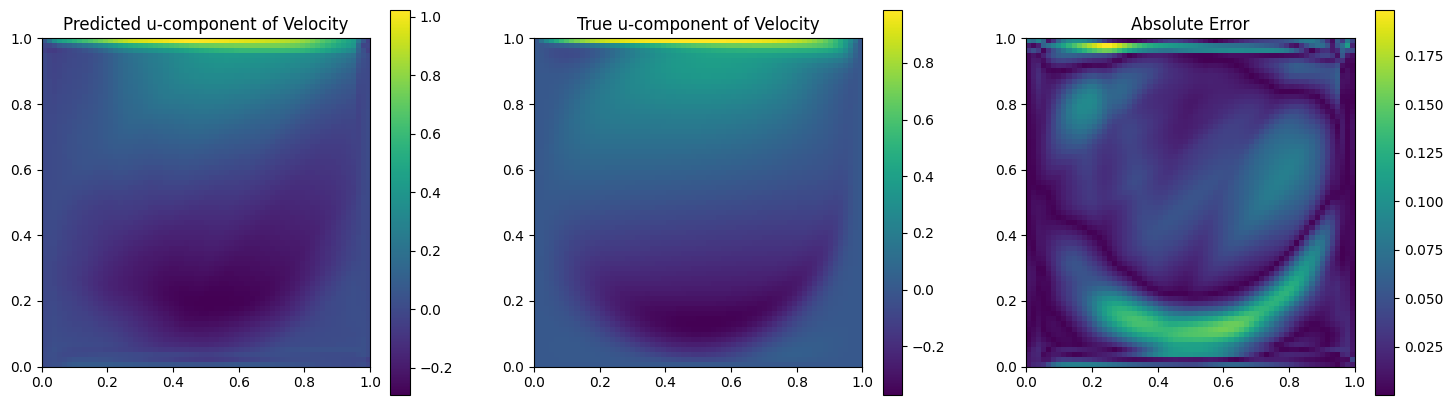

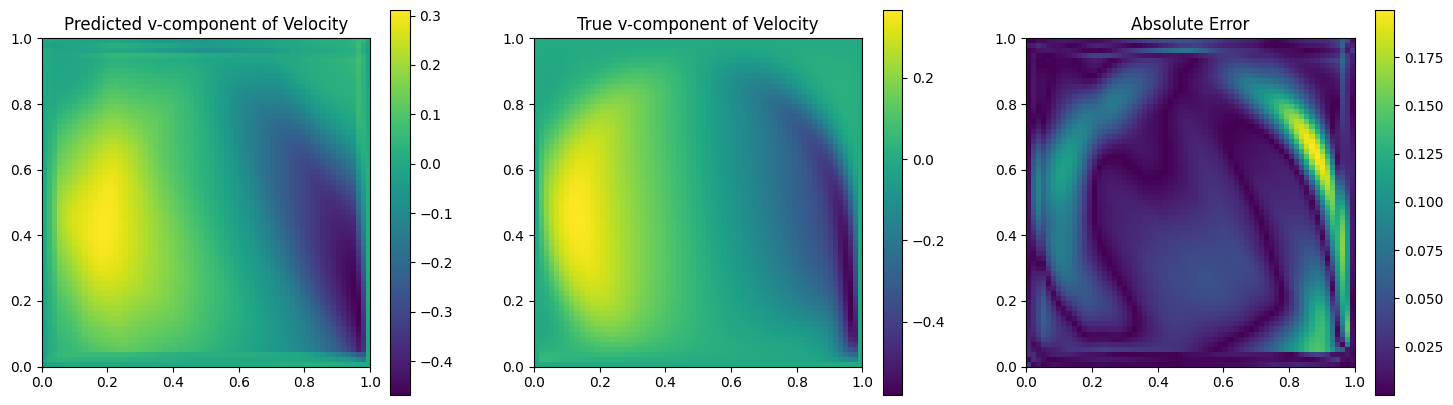

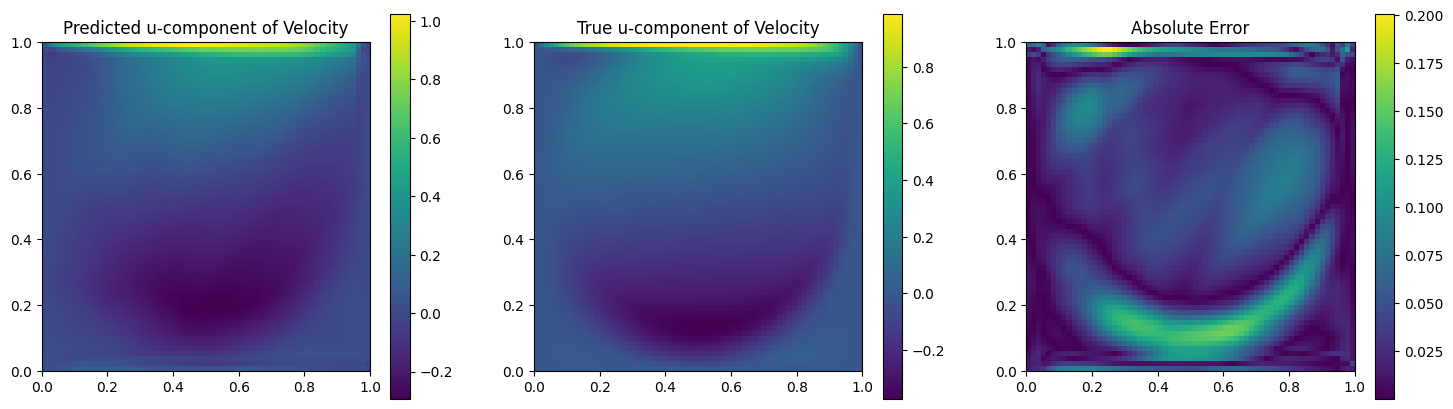

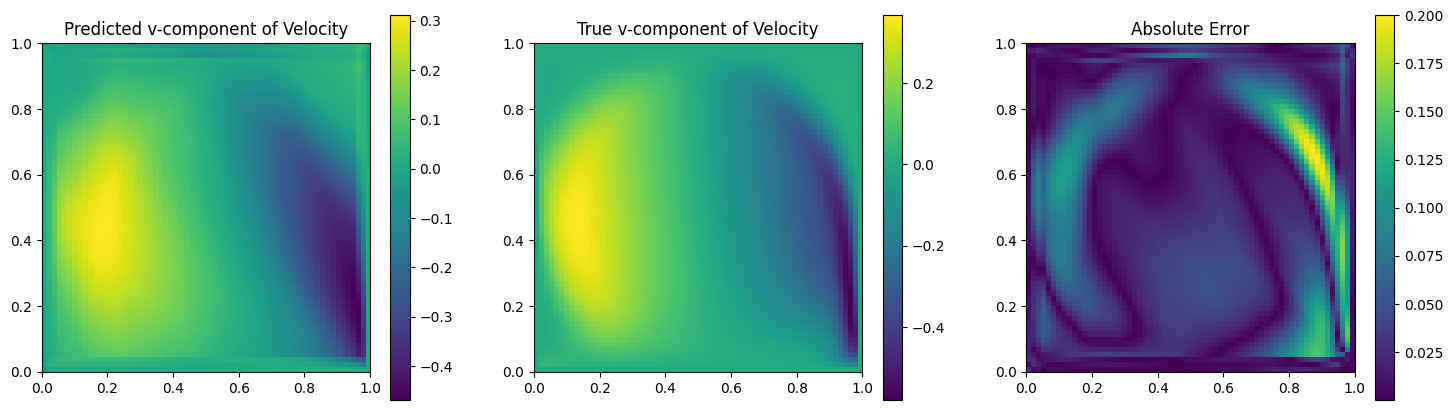

In [58]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import scipy.io 

#加载数据
data_path = './Project_IV_Data.mat'
data = scipy.io.loadmat(data_path)

# 数据分割
u_bc = data['u_bc'] #维度为100*65
expand_u_bc = torch.zeros((u_bc.shape[0], 65, 65))
expand_u_bc[:, 0, :] = torch.tensor(u_bc)  # 上边界具有非零值，维度为100*65*65
u_data = torch.tensor(data['u_data'],dtype=torch.float32) #维度为100*65*65
v_data = torch.tensor(data['v_data'],dtype=torch.float32) #维度为100*65*65
class VelocityDataset(torch.utils.data.Dataset):
    def __init__(self, expanded_bc, u_data, v_data):
        self.expanded_bc = expanded_bc
        self.u_data = u_data
        self.v_data = v_data

    def __len__(self):
        return len(self.expanded_bc)

    def __getitem__(self, idx):
        bc = self.expanded_bc[idx]
        x_2d = torch.tensor(data['x_2d'],dtype=torch.float32) #维度为65*65
        y_2d = torch.tensor(data['y_2d'],dtype=torch.float32) #维度为65*65
        mix = torch.stack([bc+x_2d, bc+y_2d], dim=0)
        u = self.u_data[idx]
        v = self.v_data[idx]
        return mix, u, v


# 创建PyTorch数据集和加载器
train_dataset = VelocityDataset(expand_u_bc[:90], u_data[:90], v_data[:90]) #维度
test_dataset = VelocityDataset(expand_u_bc[90:], u_data[90:], v_data[90:])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# 定义卷积神经网络
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.conv3(x)
        return x

# 定义训练函数，输入端应该是batch_size*3*65*65
def train(model, train_loader, test_loader, epochs, optimizer, criterion):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (mix, u, v) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(mix) 
            loss = criterion(output[:, 0, :, :], u) + criterion(output[:, 1, :, :], v)

            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Average loss: {:.6f}'.format(
                    epoch, batch_idx * len(mix), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        test(model, test_loader, criterion)
    torch.save(model.state_dict(), 'model.pth')

# 定义测试函数
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for mix, u, v in test_loader:
            output = model(mix)
            test_loss += criterion(output[:, 0, :, :], u) + criterion(output[:, 1, :, :], v)
    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.6f}'.format(test_loss.item()))


def visualize_results(model, test_loader):
    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 关闭梯度计算
        for mix, u, v in test_loader:
            output = model(mix)
            u_pred = output[:, 0, :, :].squeeze().numpy()
            v_pred = output[:, 1, :, :].squeeze().numpy()
            u_true = u.squeeze().numpy()
            v_true = v.squeeze().numpy()

            # 绘制速度场的u分量预测值和真实值，以及两者绝对误差
            plt.figure(figsize=(18, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(u_pred, origin='lower', extent=[0, 1, 0, 1])
            plt.colorbar()
            plt.title('Predicted u-component of Velocity')

            plt.subplot(1, 3, 2)
            plt.imshow(u_true, origin='lower', extent=[0, 1, 0, 1])
            plt.colorbar()
            plt.title('True u-component of Velocity')

            plt.subplot(1, 3, 3)
            plt.imshow(abs(u_true - u_pred), origin='lower', extent=[0, 1, 0, 1])
            plt.colorbar()
            plt.title('Absolute Error')
            plt.show()

            # 绘制速度场的v分量预测值和真实值
            plt.figure(figsize=(18, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(v_pred, origin='upper', extent=[0, 1, 0, 1])
            plt.colorbar()
            plt.title('Predicted v-component of Velocity')

            plt.subplot(1, 3, 2)
            plt.imshow(v_true, origin='upper', extent=[0, 1, 0, 1])
            plt.colorbar()
            plt.title('True v-component of Velocity')

            plt.subplot(1, 3, 3)
            plt.imshow(abs(v_true - v_pred), origin='upper', extent=[0, 1, 0, 1])
            plt.colorbar()
            plt.title('Absolute Error')
            plt.show()

# 定义主函数
def main():
    model = CNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train(model, train_loader, test_loader, 20, optimizer, criterion)
    visualize_results(model, test_loader)

if __name__ == '__main__':
    main()







